# Vertical Federated Learning

In [1]:
# Importing essential libraries and modules for deep learning and visualization
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

Running on cuda.


In [4]:
# Fashion_MNIST
fashion_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


## Centralized machine learning model as benchmark

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Input: [batch_size, 1, 28, 28]
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output: [batch_size, 32, 26, 26]
        # Input: [batch_size, 32, 26, 26]
        self.conv2 = nn.Conv2d(32, 64, 3) # Output: [batch_size, 64, 11, 11]
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Flattening: [batch_size, 64*5*5]
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input: [batch_size, 1, 28, 28]
        x = F.relu(self.conv1(x))
        # Shape: [batch_size, 32, 26, 26]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 32, 13, 13]
        
        x = F.relu(self.conv2(x))
        # Shape: [batch_size, 64, 11, 11]
        x = F.max_pool2d(x, 2)
        # Shape: [batch_size, 64, 5, 5]
        
        x = x.view(-1, 64 * 5 * 5) # Flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 26, 26]          320
├─Conv2d: 1-2                            [64, 64, 11, 11]          18,496
├─Linear: 1-3                            [64, 128]                 204,928
├─Linear: 1-4                            [64, 10]                  1,290
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 170.28
Input size (MB): 0.20
Forward/backward pass size (MB): 15.11
Params size (MB): 0.90
Estimated Total Size (MB): 16.21

In [111]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5
train_batch_size = 64
test_batch_size = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, num_workers=2)

model = BasicCNN().to(device)
summary(model, input_size=(train_batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BasicCNN                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 26, 26]          320
├─Conv2d: 1-2                            [64, 64, 11, 11]          18,496
├─Linear: 1-3                            [64, 128]                 204,928
├─Linear: 1-4                            [64, 10]                  1,290
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 170.28
Input size (MB): 0.20
Forward/backward pass size (MB): 15.11
Params size (MB): 0.90
Estimated Total Size (MB): 16.21

In [15]:
for epoch in range(num_epochs):
    model.train()
    print(f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in tqdm(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

Epoch 1/5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/5


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/5


  0%|          | 0/938 [00:00<?, ?it/s]

In [12]:
model.eval()
from sklearn.metrics import classification_report, confusion_matrix

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = model(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=fashion_labels))


              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.88      0.87      0.87      1000
       Dress       0.90      0.92      0.91      1000
        Coat       0.87      0.86      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.74      0.74      0.74      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [113]:
class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(640, 128) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 640)
        x = F.relu(self.fc1(x))
        return x


In [114]:
class GlobalModel(nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.fc1 = nn.Linear(256, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [115]:
c_model = ClientModel()
summary(c_model, input_size=(train_batch_size, 1, 14, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ClientModel                              [64, 128]                 --
├─Conv2d: 1-1                            [64, 32, 12, 26]          320
├─Conv2d: 1-2                            [64, 64, 4, 11]           18,496
├─Linear: 1-3                            [64, 128]                 82,048
Total params: 100,864
Trainable params: 100,864
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 63.73
Input size (MB): 0.10
Forward/backward pass size (MB): 6.62
Params size (MB): 0.40
Estimated Total Size (MB): 7.12

In [116]:
g_model = GlobalModel()
summary(g_model, input_size=(train_batch_size, 256))

Layer (type:depth-idx)                   Output Shape              Param #
GlobalModel                              [64, 10]                  --
├─Linear: 1-1                            [64, 128]                 32,896
├─Linear: 1-2                            [64, 64]                  8,256
├─Linear: 1-3                            [64, 10]                  650
Total params: 41,802
Trainable params: 41,802
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 2.68
Input size (MB): 0.07
Forward/backward pass size (MB): 0.10
Params size (MB): 0.17
Estimated Total Size (MB): 0.34

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 1, 14, 28])
torch.Size([64, 1, 14, 28])


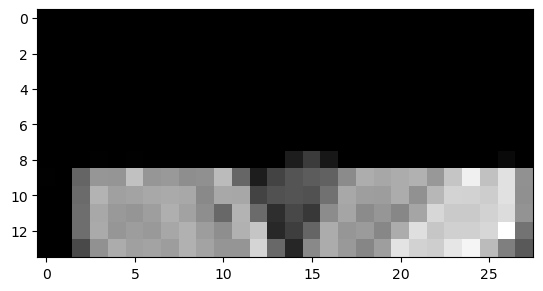

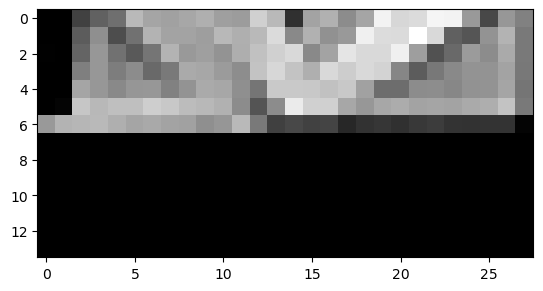

In [117]:
# Get input size of batch
datatype = trainloader.dataset.data.dtype

for X, y in trainloader:
    print(X.shape, y_batch.shape)
    X_c1 = X[:,:,:14,:]
    X_c2 = X[:,:,14:,:]
    print(X_c1.shape)
    print(X_c2.shape)
    img = X_c1[0][0]
    plt.imshow(img, cmap="gray")
    plt.show()
    img = X_c2[0][0]
    plt.imshow(img, cmap="gray")
    plt.show()

    break

In [124]:
class Client:
    def __init__(self,LocalModel):
        """
        Parameters: LocalModel (class)
        """
        self.local_model = LocalModel().to(device)
    def forward(self,data):
        data = data.to(device)
        features = self.local_model(data)
        return features
    def backward(self,errors):
        pass


class Server:
    def __init__(self,GlobalModel):
        self.global_model = GlobalModel().to(device)
        self.clients = [
            Client(ClientModel),
            Client(ClientModel)
        ]
    def forward(self,X,y):
        X_c1 = X[:,:,:14,:]
        X_c2 = X[:,:,14:,:]
        slices = [
            self.clients[0].forward(X_c1),
            self.clients[1].forward(X_c2)
        ]
        concat = torch.hstack(slices)
        print(concat.shape)
        return self.global_model(concat)

In [128]:
s = Server(GlobalModel)

In [129]:

for X, y in trainloader:
    print(X.shape, y_batch.shape)
    predictions = s.forward(X,y)
    print(predictions.shape)

    break

torch.Size([64, 1, 28, 28]) torch.Size([64])
torch.Size([64, 256])
torch.Size([64, 10])
